# Mod 4 Project

This project will provide insight of the best investment locations by Zip Code for a real-state investment firm ***X-associates***. 

The analysis is based on the information available from the Zillow Research Page, using the data in `zillow_data.csv`. 



### Methodology ###

We'll follow the OSEMN methodology:
 - Obtain
 - Scrub
 - Explore
 - Model
 - Interpret
 
The outcome of this analysis will contain the results and recommendations for the Zip Codes for ***X-associates*** 


## Obtain##

Real-state markets evolve and are affected by a complex number of factors that can go from the obvious and somehow predictable of location, mean property values, amenities, size, risks, etc to the not so obvious and unpredictable conditions like effect due to natural disasters.

The definition of what constitutes "best" for this report includes data related to historical values and other considerations as well as criteria defined by the client's preferences and areas of interest.

Our client ***X-associates*** specializes in mid-range Single family properties located in the continental U.S. and tailored for the small families that look for the conveniences of living near major metropolitan statistical areas without sacrificing space.

Knowing what the client's general expectations are, we continue with gathering the information for the analysis.

#### Load the Data/Filtering for Chosen Zipcodes ###

We have access to the data in csv format in the  `zillow_data.csv` file. Let's load and review what we are working with.

In [475]:
#loading the needed libraries
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.core import datetools
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 

In [183]:
#reading the file, examine header
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


Too many columns to display, but we notice a combination of float64 and int64 for the columns that contain the Time Series data (i.e '1996-04' is float whereas '2015-11' is int64). 

In [190]:
# Display all columns to see their type
df[:].dtypes.head(15)

RegionID        int64
RegionName      int64
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
1996-04       float64
1996-05       float64
1996-06       float64
1996-07       float64
1996-08       float64
1996-09       float64
1996-10       float64
1996-11       float64
dtype: object

Before scrubbing our data further, we select only those zipcodes we are interested in. Working with only our subset will reduce unnecessary usage of resources (in processing time and memory). We'll use the **zip_selected** dataframe to store our desired data.

In [209]:
# select only the zipcodes that we are interested for our analysis
best_zip = [60657,75070,77494,60614,79936]
zip_selected = pd.DataFrame()
for zip in best_zip:      
        zip_selected = zip_selected.append(df.loc[df['RegionName'] == zip])
zip_selected

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Scrub##

#### Data Preprocessing ####

Now that we have our selected dataframe, we would like to reshape our Time Series columns in the dataset from the **_Wide format_**, where the data for each zipcode will be in a single row and each Time Series event (month) is in a separate column; to the **_Long Format_** where each row is one time point per zipcode.

To achieve this, we'll reshape our dataframe using the `pd.melt()` method. In addition, we'll set the time column as our index to allow easy manipulation and visualization of our data.

In [474]:
#define function to reformat our data, and clean it at the same time
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank'], 
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [197]:
# using our melt_data function to reformat and storing in a temp dataset the "melted" results 
zip_melted = melt_data(zip_selected)
zip_melted.head()

,value
time,
1996-04-01,271140.0
1996-05-01,272540.0
1996-06-01,273160.0
1996-07-01,273120.0
1996-08-01,272600.0


Having the time in datetime format we can proceed with visualizing the trends of our data. 


## Explore ##

#### EDA and Visualization ###

Plotting our data allows us to identify the peaks and fails, trends and even noise.

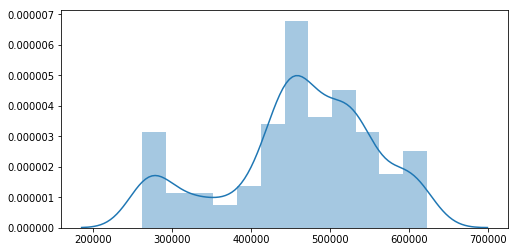

In [462]:
# plotting the distribution of the observations
fig = plt.figure(figsize = (8,4))
sns.distplot(zip_melted, hist = True, kde = True)
plt.title
plt.ylabel = ('Density')

Visually inspecting our time series, the data is not normally distributed 

In [473]:
#StandardScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt


zip_norm = pd.DataFrame()

# prepare data for standardization
values = zip_melted.values
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(zip_melted)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized = scaler.transform(zip_melted)

for zip in zip_melted:
    zip_norm = zip_norm.append()
    
    
    
for zip in best_zip:      
        zip_selected = zip_selected.append(df.loc[df['RegionName'] == zip])
zip_selected    
#    print(normalized[i])
# inverse transform and print the first 5 rows
#inversed = scaler.inverse_transform(normalized)
#for i in range(5):
#    print(inversed[i])

#scaler = StandardScaler()
#print(scaler.fit(zip_melted))
#print(scaler.mean_)
#print(scaler.transform(zip_melted))
normalized.head()

Mean: 460352.000000, StandardDeviation: 93869.517029


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
# Standardize time series data
from pandas import Series
from sklearn.preprocessing import StandardScaler
from math import sqrt

# load the dataset and print the first 5 rows
series = Series.from_csv('daily-minimum-temperatures-in-me.csv', header=0)
print(series.head())
# prepare data for standardization
values = series.values
values = values.reshape((len(values), 1))
# train the standardization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# standardization the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
	print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
	print(inversed[i])

We plot our time series and by using the autocorrelation function (ACF) we can obtain the autocorrelation of our time series as function of the time lag.

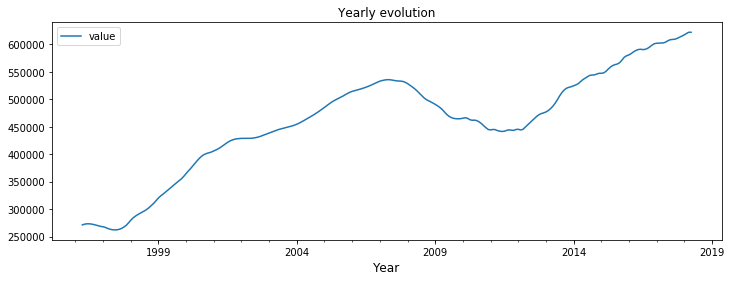

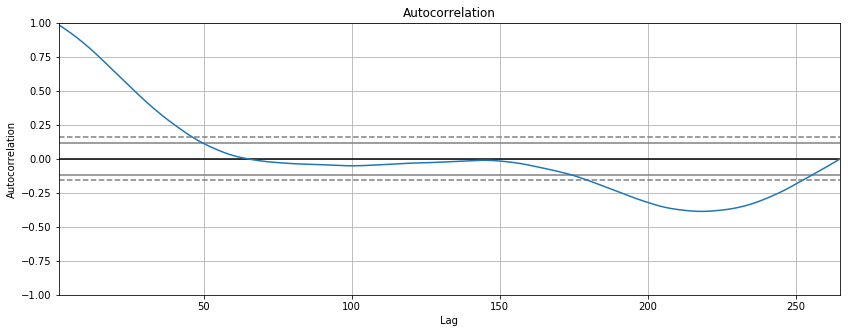

In [440]:
#drawing a line plot to see our data
zip_melted.plot(figsize = (12,4))
plt.legend(loc = 'best')
plt.title('Yearly evolution')
plt.xlabel('Year', fontsize = 12);
plt.show()

#plot the autocorrelation
pd.plotting.autocorrelation_plot(zip_melted)
plt.title('Autocorrelation')
plt.show()

Looking to our data, year by year we notice an upward trend, with downward during a period in 2008-2013 but with a nice and steady recovery after that period. Interesting significance found somewhere around 170-180 Lag. Plotting the partial autocorrelation to see the regression for the past lags. 

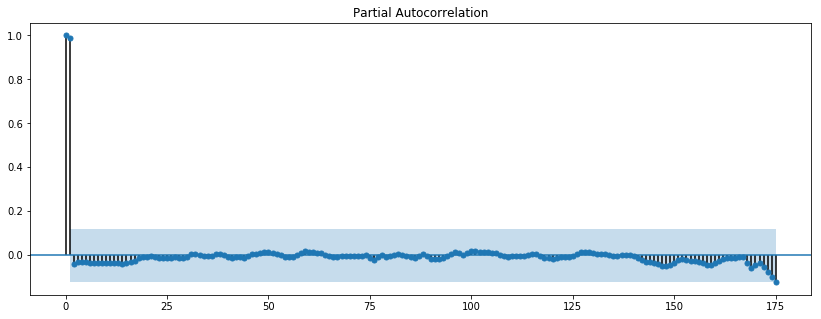

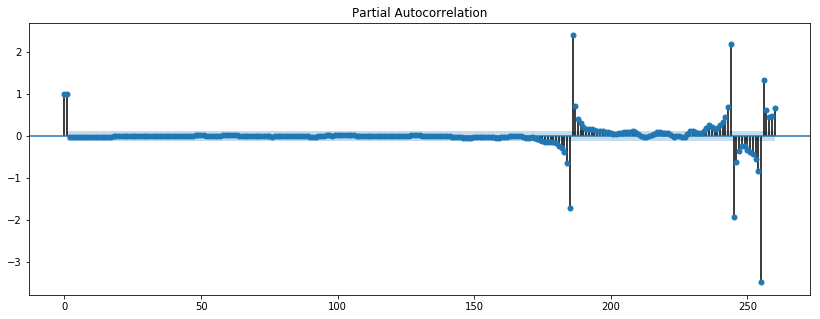

In [442]:
# graph the PACF 
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14,5

#plotting before our suspected lag of 175 and then full range
plot_pacf(zip_melted, lags = 175);
plot_pacf(zip_melted, lags = 260);

To confirm our visual identification, we will test using the formal Rolling statistics and Dickey-fuller tests. Rolling statistics allows us to visualize the moving average at any point in time; we use the rolling() function.

In [288]:
rol_mean = zip_melted.rolling(window = 12, center = False).mean()
rol_std = zip_melted.rolling(window = 12, center = False).std()

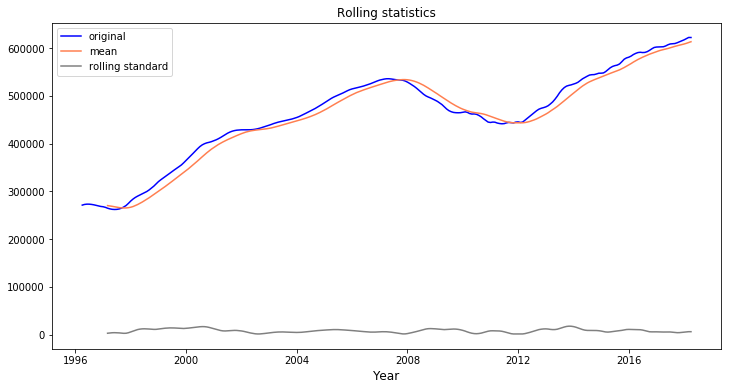

In [298]:
#drawing a line plot to see our data
fig = plt.figure(figsize = (12,6))
original = plt.plot(zip_melted, color = 'blue', label = 'original')
mean = plt.plot(rol_mean, color = 'coral', label = 'mean')
std = plt.plot(rol_std, color = 'grey', label = 'rolling standard')
plt.legend(loc = 'best')
plt.title('Rolling statistics')
plt.xlabel('Year', fontsize = 12);
plt.show()

This confirms that the mean is not constant.

Performing the test of stationarity using Dickey Fuller we seek to test the hypothesis by comparing the statistics to our critical value.

Ho : the time series is not stationary
    
Ha : the time series is stationary

We use the adfuller function for the test available in the StatsModel module.


In [318]:
# using adfuller function
dftest = adfuller(zip_melted['value'])

#format printing, for easy reading of the results
output = pd.Series(dftest[0:4], index = ['Test statistic', 'p-value', 'Lags used','Number observations'])

for key, value in dftest[4].items():
    output['Critical value (%s)'%key] = value
print(output)

Test statistic           -2.286983
p-value                   0.176201
Lags used                16.000000
Number observations     248.000000
Critical value (1%)      -3.456996
Critical value (5%)      -2.873266
Critical value (10%)     -2.573019
dtype: float64


Interpreting the results, we obtained a **p-value** that is higher to our significance level (critical value for our case of 0.05) so we would would fail to reject the null hypothesis about the time series not being stationary. 


The time series is consistent with a NOT stationary behavior. Since most models work on the assumption of stationary time series, we need to process our data before moving further. We'll apply differencing to detrend them and then run to correlation again.

In [429]:
#apply differencing
zip_diff = zip_melted.diff()
zip_diff = zip_diff.dropna()

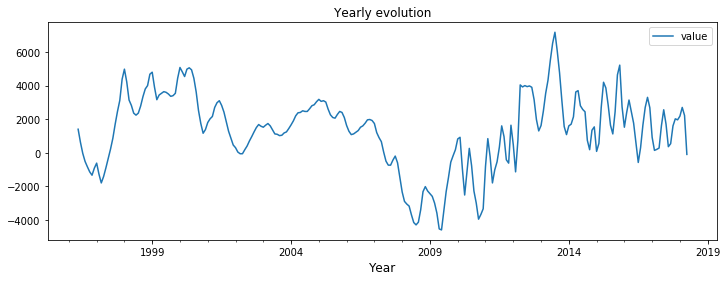

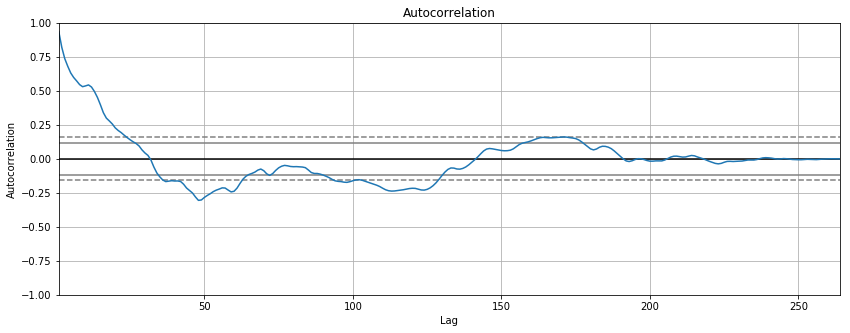

In [443]:
#plotting now the difference time set
zip_diff.plot(figsize = (12,4))
plt.legend(loc = 'best')
plt.title('Yearly evolution')
plt.xlabel('Year', fontsize = 12);
plt.show()

#plotting the correlation 
pd.plotting.autocorrelation_plot(zip_diff)
plt.title('Autocorrelation')
plt.show()

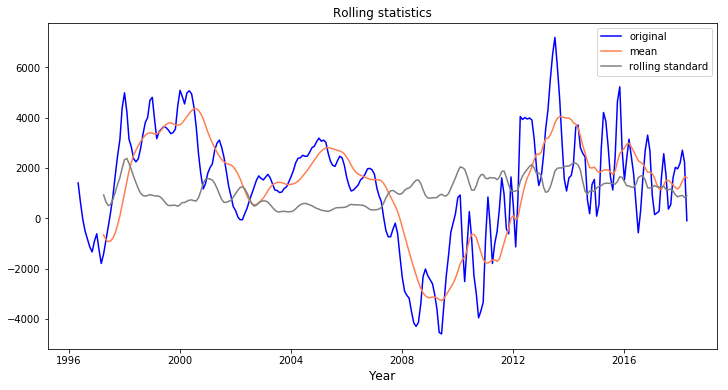

In [432]:
#Rolling statistics with the rolling() function.
rol_mean = zip_diff.rolling(window = 12, center = False).mean()
rol_std = zip_diff.rolling(window = 12, center = False).std()

#drawing a line plot to see our data
fig = plt.figure(figsize = (12,6))
original = plt.plot(zip_diff, color = 'blue', label = 'original')
mean = plt.plot(rol_mean, color = 'coral', label = 'mean')
std = plt.plot(rol_std, color = 'grey', label = 'rolling standard')
plt.legend(loc = 'best')
plt.title('Rolling statistics')
plt.xlabel('Year', fontsize = 12);
plt.show()

Visually seems that we still do not have stationarity but we'll confirm using Dickey Fuller we seek to test the hypothesis by comparing the statistics to our critical value.

In [433]:
# using adfuller function
dftest = adfuller(zip_diff['value'])

#format printing, for easy reading of the results
output = pd.Series(dftest[0:4], index = ['Test statistic', 'p-value', 'Lags used','Number observations'])

for key, value in dftest[4].items():
    output['Critical value (%s)'%key] = value
print(output)

Test statistic           -2.150539
p-value                   0.224684
Lags used                16.000000
Number observations     247.000000
Critical value (1%)      -3.457105
Critical value (5%)      -2.873314
Critical value (10%)     -2.573044
dtype: float64


**p-value** is higher to our significance level, this is not stationary.

Detrending was not enough: Decomposing would provide the components that indicate Seasonal Patterns, Trends and Random (noise). Using the statsmodel seasonal_decompose function, we'll select the Residuals and continue

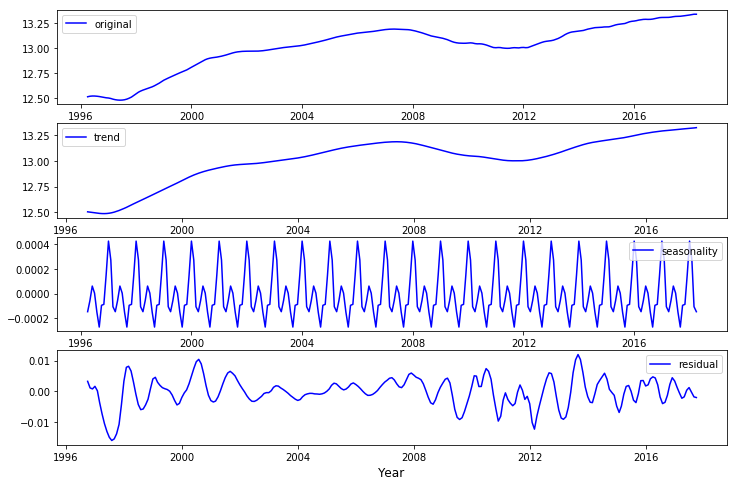

In [444]:
# normalize the time series before applying the seasonal decomposition
decomp = seasonal_decompose(np.log(zip_melted))

#gather trend, seasonality and noise
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# plot the components in different subplots

fig = plt.figure(figsize = (12,8))
plt.title('Seasonal Decompose')
plt.subplot(411)
original = plt.plot(np.log(zip_melted), color = 'blue', label = 'original')
plt.legend(loc = 'best')

plt.subplot(412)
trend = plt.plot(trend, color = 'blue', label = 'trend')
plt.legend(loc = 'best')

plt.subplot(413)
seasonal = plt.plot(seasonal, color = 'blue', label = 'seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
residual = plt.plot(residual, color = 'blue', label = 'residual')
plt.legend(loc = 'best')

plt.xlabel('Year', fontsize = 12);
plt.show()

We note an interesting behavior of the residuals after 2018. We'll check the stationarity of the Residuals.

In [450]:
# normalize the time series before applying the seasonal decomposition
zip_log = np.log(zip_melted)
zip_log.head()

,value
time,
1996-04-01,12.510391
1996-05-01,12.515541
1996-06-01,12.517813
1996-07-01,12.517667
1996-08-01,12.515761


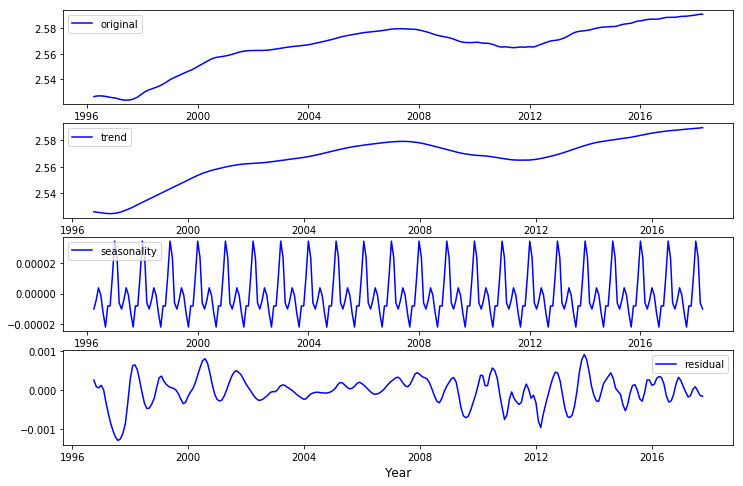

In [454]:
# normalize the time series before applying the seasonal decomposition
decomp = seasonal_decompose(np.log(zip_log))

#gather trend, seasonality and noise
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# plot the components in different subplots

fig = plt.figure(figsize = (12,8))
plt.title('Seasonal Decompose')
plt.subplot(411)
original_log = plt.plot(np.log(zip_log), color = 'blue', label = 'original')
plt.legend(loc = 'best')

plt.subplot(412)
trend = plt.plot(trend, color = 'blue', label = 'trend')
plt.legend(loc = 'best')

plt.subplot(413)
seasonal = plt.plot(seasonal, color = 'blue', label = 'seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
residual = plt.plot(residual, color = 'blue', label = 'residual')
plt.legend(loc = 'best')

plt.xlabel('Year', fontsize = 12);
plt.show()

By using the autocorrelation function (ACF) we can obtain the autocorrelation of our time series as function of the time lag.

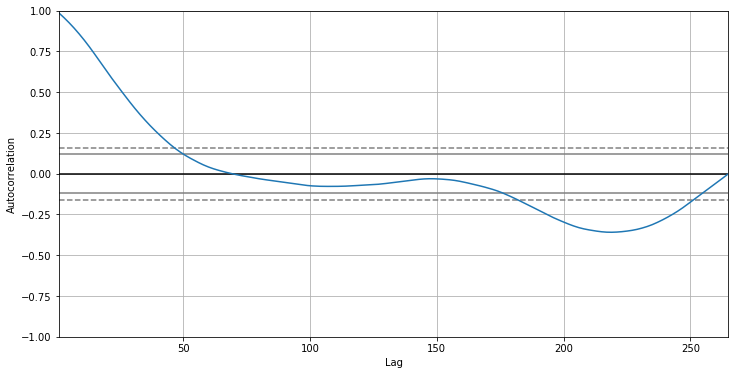

In [476]:
#checking and plotting autocorrelation
plt.figure(figsize = (12,6))
pd.plotting.autocorrelation_plot(zip_log)

It shows a strong and longlasting correlation for the period of our time series data (aprox 20 years) with an interesting significance again somewhere around 170-180 Lag. Plotting the partial autocorrelation to see the regression for the past lags. 

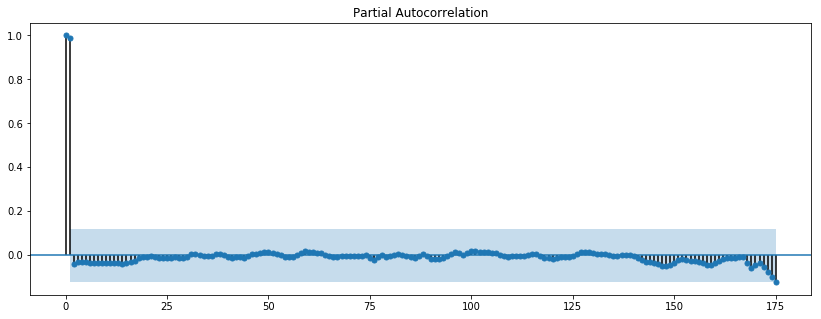

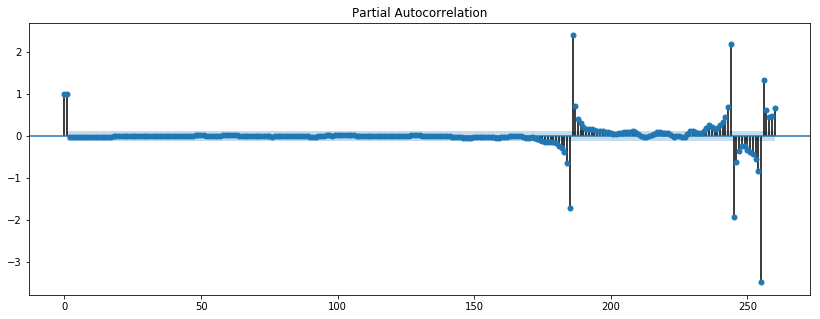

If we only considered the first 174 lags of our data (From April 1996 to October 2010) we could easily recognize a second order to our model; however there is significance after lag 175 (November 2010) which leads me to investigate further from that period onwards.

In [478]:
ts_log_dec = zip_log['value']
ts_log_dec.dropna(inplace=True)

# using adfuller function
dftest = adfuller(ts_log_dec)

#format printing, for easy reading of the results
output = pd.Series(dftest[0:4], index = ['Test statistic', 'p-value', 'Lags used','Number observations'])

for key, value in dftest[4].items():
    output['Critical value (%s)'%key] = value
print(output)

Test statistic           -3.271815
p-value                   0.016186
Lags used                16.000000
Number observations     248.000000
Critical value (1%)      -3.456996
Critical value (5%)      -2.873266
Critical value (10%)     -2.573019
dtype: float64


In [236]:
#grouping values per year, only for those years that we have complete data
year_groups = zip_melted['1997':'2017'].groupby(pd.Grouper(freq = 'A'))

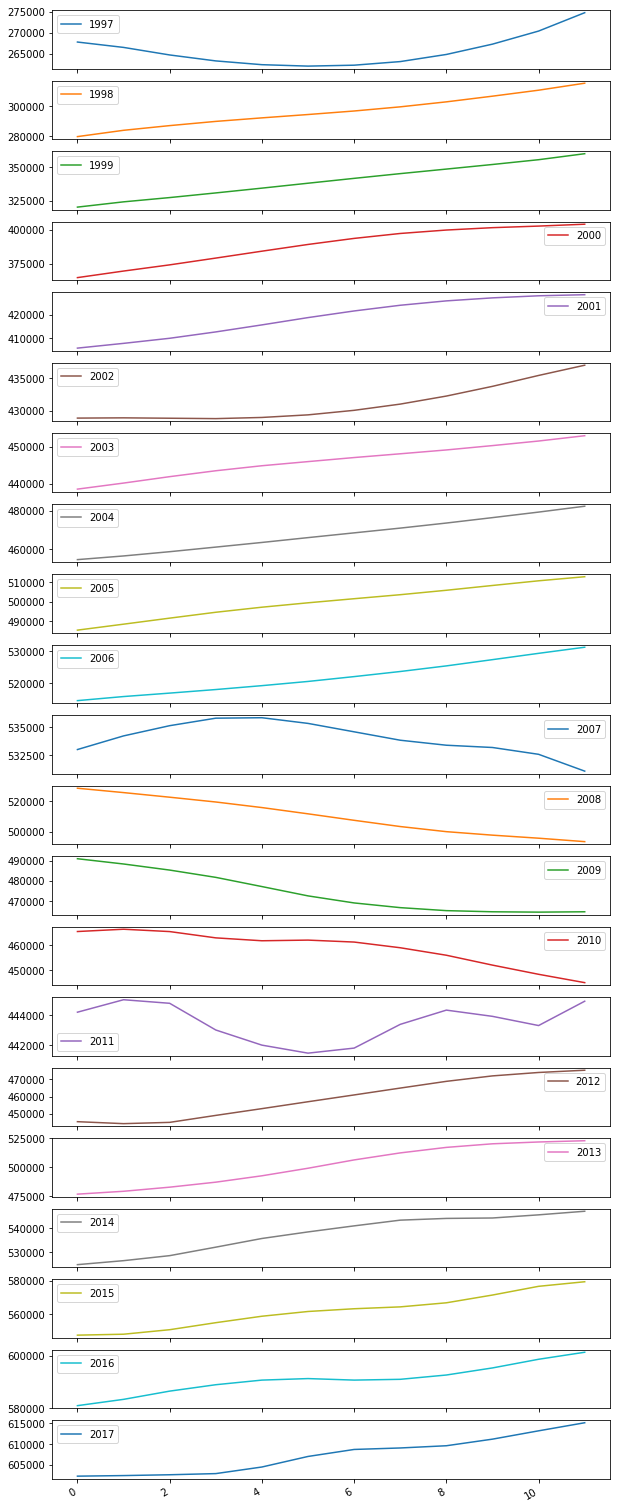

In [276]:
#create a new dataframe to store the yearly grouped values
zip_annual = pd.DataFrame()

for yr, group in year_groups:
    zip_annual[yr.year] = group.values.ravel()
    
#plot the yearly groups
zip_annual.plot(figsize = (10,30), subplots = True, legend = True)
plt.show()

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Distribution is not normal

## Modeling ##


We look to model our time series to try to predict the future.  

#### ARIMA Modeling ####

## Interpreting Results ##